In [78]:
import os
from tqdm import tqdm
from src.utils import *
from src.params import *
from ranger import Ranger20
import matplotlib.pyplot as plt
from src.dataset import RapidEye
from sklearn.metrics import jaccard_score
from torch.nn import CrossEntropyLoss, Conv2d
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split
from torchvision.models.segmentation import fcn_resnet101
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomCrop, CenterCrop, Normalize

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
normalize = Normalize(mean=train_mean_rgb, std=train_std_rgb)

train_transforms = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

test_transforms = Compose([
    CenterCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

In [4]:
train_dataset = RapidEye(
    band="RGB",
    img_dir=train_path,
    mask_dir=mask_path,
    transform=train_transforms
)
train_dataset, val_dataset = random_split(
    train_dataset,
    lengths=[int(len(train_dataset) * 0.8), len(train_dataset) - int(len(train_dataset) * 0.8)]
)
test_dataset = RapidEye(
    band="RGB",
    mask_dir=None,
    img_dir=test_path,
    transform=test_transforms
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
val_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=val_dataset,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
test_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_dataset,
    pin_memory=True,
    num_workers=0,
)

In [5]:
fcn = fcn_resnet101(pretrained=True, progress=True)
for layer in fcn.backbone.parameters():
    layer.requires_grad = False
fcn.classifier[4] = Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
fcn = fcn.to(device)
criterion = CrossEntropyLoss()
optimizer = Ranger20(fcn.parameters())

records = { "train_loss": [], "val_loss": [], "val_iou": [], "val_acc": [] }

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [6]:
for epoch in range(EPOCH):
    fcn.train()

    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        x, mask = data
        x = x.to(device)
        mask = mask.to(device)
        y_pred = fcn(x)
        y_pred = y_pred["out"]

        loss = criterion(y_pred, mask)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Iteration {i} / Epoch {epoch}: Training Loss {loss}")
    train_loss /= len(train_loader)
    records["train_loss"].append(train_loss.item())

    with torch.no_grad():
        fcn.eval()
        val_iou = 0
        val_acc = 0
        val_loss = 0

        for i, data in tqdm(enumerate(val_loader)):
            x, mask = data
            x = x.to(device)
            mask = mask.to(device)
            y_pred = fcn(x)
            y_pred = y_pred["out"]

            loss = criterion(y_pred, mask)
            val_loss += loss

            y_pred = y_pred.argmax(axis=1)
            val_acc += torch.eq(y_pred, mask).float().mean()
            val_iou += jaccard_score(y_pred.reshape(-1).cpu(), mask.reshape(-1).cpu(), average="weighted")

    val_acc /= len(val_loader)
    val_iou /= len(val_loader)
    val_loss /= len(val_loader)

    records["val_acc"].append(val_acc.item())
    records["val_iou"].append(val_iou.item())
    records["val_loss"].append(val_loss.item())

    print(f"Epoch {epoch}: Validation Loss {val_loss} | Validation Pixel-wise Accuracy: {val_acc} | Validation IoU: {val_iou}")

23it [00:12,  1.88it/s]
6it [00:03,  1.54it/s]
23it [00:11,  2.09it/s]
6it [00:04,  1.49it/s]
23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
23it [00:11,  2.08it/s]
6it [00:03,  1.53it/s]
23it [00:10,  2.09it/s]
6it [00:03,  1.53it/s]
23it [00:11,  2.09it/s]
6it [00:03,  1.53it/s]
23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
23it [00:11,  2.09it/s]
6it [00:04,  1.49it/s]
23it [00:11,  2.07it/s]
6it [00:04,  1.48it/s]
23it [00:11,  2.07it/s]
6it [00:04,  1.50it/s]
23it [00:11,  2.09it/s]
6it [00:03,  1.54it/s]
23it [00:10,  2.13it/s]
6it [00:03,  1.53it/s]
23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
23it [00:10,  2.13it/s]
6it [00:03,  1.51it/s]
23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
23it [00:10,  2.11it/s]
6it [00:03,  1.52it/s]
23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
23it [00:10,  2.14it/s]
6it [00:03,  1.52it/s]
23it [00:10, 

Iteration 9 / Epoch 0: Training Loss 1.09233820438385
Iteration 19 / Epoch 0: Training Loss 1.0716851949691772
Epoch 0: Validation Loss 1.0661115646362305 | Validation Pixel-wise Accuracy: 0.40687716007232666 | Validation IoU: 0.3437824090214827
Iteration 9 / Epoch 1: Training Loss 1.0100996494293213
Iteration 19 / Epoch 1: Training Loss 0.9881368279457092
Epoch 1: Validation Loss 1.0643839836120605 | Validation Pixel-wise Accuracy: 0.4397132396697998 | Validation IoU: 0.36859978303772545
Iteration 9 / Epoch 2: Training Loss 0.9749682545661926
Iteration 19 / Epoch 2: Training Loss 0.9520378708839417
Epoch 2: Validation Loss 0.9663441181182861 | Validation Pixel-wise Accuracy: 0.5744216442108154 | Validation IoU: 0.40767542435697895
Iteration 9 / Epoch 3: Training Loss 0.9435793161392212
Iteration 19 / Epoch 3: Training Loss 0.9449445605278015
Epoch 3: Validation Loss 0.8747029304504395 | Validation Pixel-wise Accuracy: 0.6249922513961792 | Validation IoU: 0.4641801448029614
Iteration 9

In [7]:
if not os.path.exists(model_path):
    os.mkdir(model_path)
torch.save(fcn.state_dict(), f"{model_path}/fcn_coco_rgb")

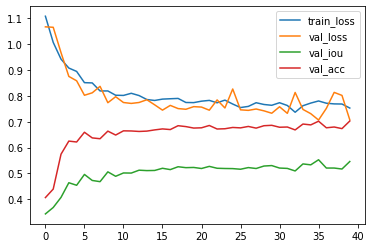

In [8]:
xs = range(EPOCH)
for key, data in records.items():
    plt.plot(xs, data, label=key)
plt.legend()

(128, 128, 3)


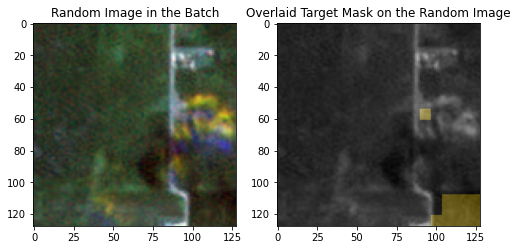

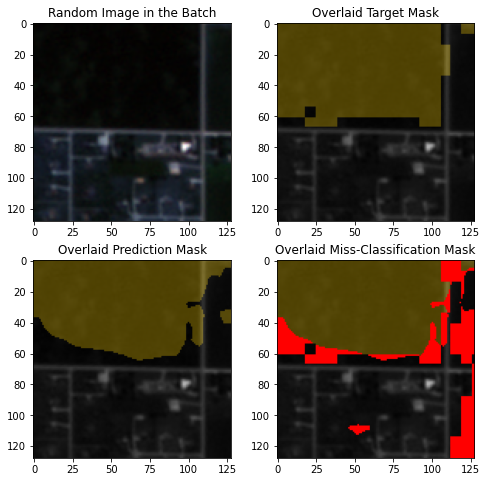

In [87]:
x, y = next(iter(train_loader))
y_pred = fcn(x.to(device))["out"].argmax(axis=1)
visualize_sample(x, y)
visualize_pred(x, y_pred, y)
